<H3>The objective of this analysis is to model how demographic factors influence the number of ice cream shops in a given town and then use the model to determine which towns in the state of Massachusetts have fewer shops than they should based on demographics. Data from the state of Connecticut will be used to train the model.

In [987]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import math
import sklearn
import seaborn as sns
import matplotlib as mp
from pandas.io.json import json_normalize

<H3>Connecticut population information is imported as a dataframe from a csv file and the dataframe is sliced to provide just the total population for each town.

In [340]:
conn_demo = pd.read_csv('/Users/matthewowen/Documents/Coursera/population-by-age-town-2018.csv', header = 0)


In [349]:
conn_age = conn_demo[(conn_demo['Race/Ethnicity']=='All') & (conn_demo['Year']=='2014-2018') & (conn_demo['Gender']=='Total') & (conn_demo['Variable']=='Population') & (conn_demo['Measure Type']=='Number')]


In [458]:
conn_pop = conn_age[conn_age['Age Cohort']=='Total']

conn_pop.drop(labels = 'Age Cohort', axis = 1, inplace=True)

In [459]:
conn_pop.rename(columns = {'Value' : 'Population'}, inplace=True)

conn_pop.head()

,Town,Population
16060,Andover,3223.0
32660,Ansonia,18860.0
49260,Ashford,4234.0
65860,Avon,18338.0
82460,Barkhamsted,3671.0


<H3>Data for the median age, land area, per capita income, and total households is also imported, sliced, and cleaned.

In [362]:
conn_med = pd.read_csv('/Users/matthewowen/Documents/Coursera/medianagetown2018.csv', header = 0)

conn_med.head(3)

,Town,FIPS,Year,Gender,Race/Ethnicity,Measure Type,Variable,Value
0,Andover,901301080,2006-2010,Female,All,Number,Median Age,42.8
1,Andover,901301080,2006-2010,Female,All,Number,Margins of Error,2.2
2,Andover,901301080,2006-2010,Female,American Indian and Alaska Native Alone,Number,Median Age,-9999.0


In [946]:
conn_median = conn_med[(conn_med['Year'] == '2014-2018') & (conn_med['Gender'] == 'Total') & (conn_med['Race/Ethnicity'] == 'All') & (conn_med['Variable'] == 'Median Age')]

In [947]:
conn_median.drop(labels = conn_median[conn_median['Town']=='Connecticut'].index, axis=0, inplace=True)

conn_median.head()

,Town,FIPS,Year,Gender,Race/Ethnicity,Measure Type,Variable,Value
520,Andover,901301080,2014-2018,Total,All,Number,Median Age,45.4
1060,Ansonia,900901220,2014-2018,Total,All,Number,Median Age,39.6
1600,Ashford,901501430,2014-2018,Total,All,Number,Median Age,45.7
2140,Avon,900302060,2014-2018,Total,All,Number,Median Age,45.8
2680,Barkhamsted,900502760,2014-2018,Total,All,Number,Median Age,46.7


In [369]:
area = pd.read_csv('/Users/matthewowen/Documents/Coursera/landareabytown.csv', header=0)

area.head()

,Town,FIPS,Year,Measure Type,Variable,Value
0,Connecticut,9,2000,Square Miles,Land Area,4844.78
1,Connecticut,9,2010,Square Miles,Land Area,4842.33
2,Bethel,900104720,2000,Square Miles,Land Area,16.79
3,Bethel,900104720,2010,Square Miles,Land Area,16.89
4,Bridgeport,900108070,2000,Square Miles,Land Area,16.00


In [450]:
conn_area = area[area['Year']==2010]

conn_area.sort_values(by = ['Town'], inplace=True)

conn_area.head()

,Town,FIPS,Year,Measure Type,Variable,Value
285,Andover,901301080,2010,Square Miles,Land Area,15.45
189,Ansonia,900901220,2010,Square Miles,Land Area,6.02
311,Ashford,901501430,2010,Square Miles,Land Area,38.76
49,Avon,900302060,2010,Square Miles,Land Area,23.15
107,Barkhamsted,900502760,2010,Square Miles,Land Area,36.25


In [382]:
percap = pd.read_csv('/Users/matthewowen/Documents/Coursera/percapitaincometown2018.csv', header = 0)

percap.head()

,Town,FIPS,Year,Race/Ethnicity,Measure Type,Variable,Value
0,Andover,901301080,2005-2009,All,Number,Per Capita Income,38825
1,Andover,901301080,2005-2009,All,Number,Margins of Error,5060
2,Andover,901301080,2005-2009,American Indian and Alaska Native Alone,Number,Per Capita Income,-9999
3,Andover,901301080,2005-2009,American Indian and Alaska Native Alone,Number,Margins of Error,-9999
4,Andover,901301080,2005-2009,Asian Alone,Number,Per Capita Income,-9999


In [405]:
conn_percap = percap[(percap['Year']=='2014-2018') & (percap['Race/Ethnicity']=="All") & (percap['Variable']=="Per Capita Income")]

conn_percap.head()

,Town,FIPS,Year,Race/Ethnicity,Measure Type,Variable,Value
180,Andover,901301080,2014-2018,All,Number,Per Capita Income,41260
380,Ansonia,900901220,2014-2018,All,Number,Per Capita Income,28009
580,Ashford,901501430,2014-2018,All,Number,Per Capita Income,36212
780,Avon,900302060,2014-2018,All,Number,Per Capita Income,72594
980,Barkhamsted,900502760,2014-2018,All,Number,Per Capita Income,44722


In [384]:
hh = pd.read_csv('/Users/matthewowen/Documents/Coursera/total-households-town-2018.csv', header=0)

hh.head()

,Town,FIPS,Year,Measure Type,Variable,Value
0,Andover,901301080,2006-2010,Number,Total Households,1276
1,Andover,901301080,2006-2010,Number,Margins of Error,76
2,Andover,901301080,2007-2011,Number,Total Households,1203
3,Andover,901301080,2007-2011,Number,Margins of Error,92
4,Andover,901301080,2008-2012,Number,Total Households,1135


In [431]:
conn_hh = hh[(hh['Year']=='2014-2018') & (hh["Variable"]=='Total Households')]

conn_hh.head()

,Town,FIPS,Year,Measure Type,Variable,Value
16,Andover,901301080,2014-2018,Number,Total Households,1235
34,Ansonia,900901220,2014-2018,Number,Total Households,7452
52,Ashford,901501430,2014-2018,Number,Total Households,1780
70,Avon,900302060,2014-2018,Number,Total Households,6968
88,Barkhamsted,900502760,2014-2018,Number,Total Households,1364


<H3>The relevant data from each of the Connecticut dataframes is combined into a single dataframe

In [703]:
conn_data = conn_pop.loc[:,:]

MA = list(conn_median.loc[:,"Value"])
PCI = list(conn_percap.loc[:,"Value"])
HH = list(conn_hh.loc[:,'Value'])
LA = list(conn_area.loc[:,'Value'])

conn_data['Median Age'] = MA
conn_data['Per Capita Income'] = PCI
conn_data["Total Households"] = HH
conn_data['Land Area'] = LA

In [462]:
conn_data.head()

,Town,Population,Median Age,Per Capita Income,Total Households,Land Area
16060,Andover,3223.0,45.4,41260,1235,15.45
32660,Ansonia,18860.0,39.6,28009,7452,6.02
49260,Ashford,4234.0,45.7,36212,1780,38.76
65860,Avon,18338.0,45.8,72594,6968,23.15
82460,Barkhamsted,3671.0,46.7,44722,1364,36.25


In [463]:
conn_data.drop(labels = conn_data[conn_data['Town']=='Connecticut'].index, axis=0, inplace=True)

<H3>New columns are created for the calculated values of average household size and the population per square mile. The columns for the 'land area' and 'total households' are then dropped from the dataframe.

In [464]:
conn_data['Avg Household Size'] = list(round(conn_data['Population'] / conn_data['Total Households'],2))
conn_data['Population per Sq Mile'] = list(round(conn_data['Population'] / conn_data['Land Area'], 2))

In [593]:
conn_data.drop(labels = ['Total Households', 'Land Area'], axis = 1, inplace=True)

In [706]:
conn_data.reset_index(inplace=True)

conn_data.drop(labels = 'index', axis =1, inplace=True)

conn_data.head()

,Town,Population,Median Age,Per Capita Income,Avg Household Size,Population per Sq Mile
0,Andover,3223.0,45.4,41260,2.61,208.61
1,Ansonia,18860.0,39.6,28009,2.53,3132.89
2,Ashford,4234.0,45.7,36212,2.38,109.24
3,Avon,18338.0,45.8,72594,2.63,792.14
4,Barkhamsted,3671.0,46.7,44722,2.69,101.27


<H3>The entries in the 'town' column are used to generate an alphabetical list of all of the towns in Connecticut.

In [596]:
conn_town_list = list(conn_data.loc[ : , 'Town'])

In [597]:
conn_town_list

['Andover',
 'Ansonia',
 'Ashford',
 'Avon',
 'Barkhamsted',
 'Beacon Falls',
 'Berlin',
 'Bethany',
 'Bethel',
 'Bethlehem',
 'Bloomfield',
 'Bolton',
 'Bozrah',
 'Branford',
 'Bridgeport',
 'Bridgewater',
 'Bristol',
 'Brookfield',
 'Brooklyn',
 'Burlington',
 'Canaan',
 'Canterbury',
 'Canton',
 'Chaplin',
 'Cheshire',
 'Chester',
 'Clinton',
 'Colchester',
 'Colebrook',
 'Columbia',
 'Cornwall',
 'Coventry',
 'Cromwell',
 'Danbury',
 'Darien',
 'Deep River',
 'Derby',
 'Durham',
 'East Granby',
 'East Haddam',
 'East Hampton',
 'East Hartford',
 'East Haven',
 'East Lyme',
 'East Windsor',
 'Eastford',
 'Easton',
 'Ellington',
 'Enfield',
 'Essex',
 'Fairfield',
 'Farmington',
 'Franklin',
 'Glastonbury',
 'Goshen',
 'Granby',
 'Greenwich',
 'Griswold',
 'Groton',
 'Guilford',
 'Haddam',
 'Hamden',
 'Hampton',
 'Hartford',
 'Hartland',
 'Harwinton',
 'Hebron',
 'Kent',
 'Killingly',
 'Killingworth',
 'Lebanon',
 'Ledyard',
 'Lisbon',
 'Litchfield',
 'Lyme',
 'Madison',
 'Manchester

<H3>A dataframe of ice cream shops in Connecticut is constructed by using the 'near' endpoint of the Foursquare API to find venues with the 'ice cream shop' category located near each town in the state.

In [507]:
CLIENT_ID = 'BMZ1NFZ3Y2RQATXBXMADBSRSUARDBCDGUQWGNMIP23LCQ25K'
CLIENT_SECRET = '[Redacted]'
VERSION = '20200205'
cat_ID = '4bf58dd8d48988d1c9941735'

In [598]:
conn_venue_df = pd.DataFrame()

for town in conn_town_list:

    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&categoryId={}&v={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        town + ', CT',
        cat_ID,
        VERSION,
        100
        )
    
    req = requests.get(url).json()
   
    try:
        ven = req['response']['venues']
    except:
        print('Problem occurred with ' + town)
    else:
        df = json_normalize(ven)
    
        conn_venue_df = conn_venue_df.append(df, ignore_index=True)

<H3>The venue dataframe is sliced to include only Connecticut venues and only the name of the venue and its city.

In [601]:
conn_venue_df['location.state'].value_counts()

CT               6878
NY                357
MA                271
RI                163
Connecticut        46
Rhode Island       21
Massachusetts      13
Name: location.state, dtype: int64

In [602]:
venue_CT = conn_venue_df[(conn_venue_df['location.state']=='CT') | (conn_venue_df['location.state']=='Connecticut')]

In [605]:
Conn_venues = venue_CT.loc[:,['name', 'location.city']]

<H3>A function is defined to retrieve the name of the primary category for each venue from the original dataframe, this information is added to the new venue dataframe, and duplicated values are removed.

In [147]:
def get_category_type(row):
    categories_list = row['categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [606]:
Conn_venues['Category'] = venue_CT.apply(get_category_type, axis=1)

In [607]:
Conn_venues.drop_duplicates(inplace=True)

In [609]:
Conn_venues.head()

,name,location.city,Category
0,Dairy Queen,Manchester,Ice Cream Shop
1,Kiwi Spoon,Rocky Hill,Frozen Yogurt Shop
2,Rita's Italian Ice & Frozen Custard,Rocky Hill,Ice Cream Shop
3,Friendly's,Willimantic,Restaurant
4,Shady Glen Restaurant,Manchester,American Restaurant


<H3>The venue dataframe is sliced to only include venues designated as either an ice cream shop or a frozen yogurt shop.

In [610]:
CT_venues = Conn_venues[(Conn_venues['Category']=='Ice Cream Shop') | (Conn_venues['Category']=='Frozen Yogurt Shop')]

<H3>A list is generated of the city designations in the venue dataframe that don't match official town names. These values are then replaced with the correct designation in the dataframe.

In [707]:
not_town_CT = CT_venues[~CT_venues['location.city'].isin(conn_town_list)]

In [708]:
not_town_CT['location.city'].value_counts()

Mystic                  4
Moosup                  3
Pawcatuck               3
Amston                  2
Preston Township        2
Winsted                 2
Storrs                  2
Niantic                 2
Milldale                2
Centerbrook             2
Jewett City             2
Westbrook Center        2
South Lyme              1
South Coventry          1
Town of Mansfield       1
Town of Ledyard         1
Branford Center         1
Stafford Springs        1
Uncasville              1
Town of East Windsor    1
Willimantic             1
Gales Ferry             1
Town of Winchester      1
West Redding            1
Woodstock Valley        1
Pomfret Center          1
Taftville               1
East Killingly          1
Moodus                  1
Name: location.city, dtype: int64

In [715]:
CT_town_replace = {
    'Moosup' : 'Plainfield',
    'Pawcatuck' : 'Stonington',
    'Amston' : 'Hebron',
    'Preston Township' : 'Preston',
    'Winsted' : 'Winchester',
    'Storrs' : 'Mansfield',
    'Niantic' : 'East Lyme',
    'Milldale' : 'Southington',
    'Centerbrook' : 'Essex',
    'Jewett City' : 'Griswold',
    'Westbrook Center' : 'Westbrook',
    'South Lyme' : 'Old Lyme',
    'South Coventry' : 'Coventry',
    'Town of Mansfield' : 'Mansfield',
    'Town of Ledyard' : 'Ledyard',
    'Branford Center' : 'Branford',
    'Stafford Springs' : 'Stafford',
    'Uncasville' : 'Montville',
    'Town of East Windsor' : 'East Windsor',
    'Willimantic' : 'Windham',
    'Gales Ferry' : 'Ledyard',
    'Town of Winchester' : 'Winchester',
    'West Redding' : 'Redding',
    'Woodstock Valley' : 'Woodstock',
    'Pomfret Center' : 'Pomfret',
    'Taftville' : 'Norwich',
    'East Killingly' : 'Killingly',
    'Moodus' : 'East Haddam'
    }

In [716]:
CT_venues2 = CT_venues.replace(to_replace = CT_town_replace)

In [726]:
CT_venues2[CT_venues2['location.city']=='Mystic'].index

Int64Index([581, 597, 612, 629], dtype='int64')

In [727]:
CT_venues2.loc[581, 'location.city'] = 'Groton'
CT_venues2.loc[597, 'location.city'] = 'Groton'
CT_venues2.loc[612, 'location.city'] = 'Stonington'
CT_venues2.loc[629, 'location.city'] = 'Stonington'

<H3>Venue dataframe values are grouped by town name and then a list is generated to denote the number of ice cream shops in each town (zero if the town does not appear in the venue dataframe).

In [728]:
CT_venue_count = CT_venues2.groupby(by='location.city').count()

CT_venue_count.head()

,name,Category
location.city,,
Ashford,1,1
Avon,3,3
Berlin,2,2
Bethany,1,1
Bethel,3,3


In [731]:
CT_venue_towns = list(CT_venues2.loc[ : , 'location.city'])

In [732]:
CT_ic_shops = []

for town in conn_town_list:
    
    if town in CT_venue_towns:
        CT_ic_shops += [CT_venue_count.loc[town, 'name']]
        
    else:
        CT_ic_shops += [0]
    

In [733]:
CT_ic_shops

[0,
 0,
 1,
 3,
 0,
 0,
 2,
 1,
 3,
 0,
 1,
 1,
 0,
 2,
 5,
 0,
 4,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 4,
 1,
 2,
 2,
 0,
 0,
 0,
 1,
 3,
 7,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 3,
 2,
 1,
 0,
 0,
 1,
 4,
 3,
 7,
 2,
 0,
 3,
 1,
 2,
 1,
 2,
 3,
 4,
 0,
 3,
 0,
 1,
 0,
 0,
 4,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 5,
 3,
 0,
 3,
 0,
 0,
 5,
 7,
 4,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 7,
 5,
 1,
 2,
 2,
 0,
 2,
 0,
 3,
 2,
 5,
 2,
 4,
 5,
 2,
 3,
 5,
 3,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 4,
 3,
 0,
 1,
 0,
 0,
 1,
 0,
 3,
 0,
 2,
 0,
 4,
 1,
 8,
 0,
 1,
 5,
 0,
 5,
 1,
 2,
 0,
 1,
 2,
 4,
 0,
 0,
 2,
 0,
 3,
 0,
 0,
 6,
 5,
 1,
 7,
 1,
 3,
 0,
 3,
 1,
 0,
 2,
 3,
 1,
 1,
 2,
 0,
 0,
 2,
 1]

<H3>A column is added to the Connecticut dataframe to indicate the number of shops in each town.

In [734]:
conn_data['# of Ice Cream Shops'] = CT_ic_shops

In [737]:
conn_data.head(10)

,Town,Population,Median Age,Per Capita Income,Avg Household Size,Population per Sq Mile,# of Ice Cream Shops
0,Andover,3223.0,45.4,41260,2.61,208.61,0
1,Ansonia,18860.0,39.6,28009,2.53,3132.89,0
2,Ashford,4234.0,45.7,36212,2.38,109.24,1
3,Avon,18338.0,45.8,72594,2.63,792.14,3
4,Barkhamsted,3671.0,46.7,44722,2.69,101.27,0
5,Beacon Falls,6115.0,45.4,43137,2.48,632.37,0
6,Berlin,20519.0,48.1,48602,2.49,779.60,2
7,Bethany,5504.0,48.8,55103,2.80,260.48,1
8,Bethel,19551.0,43.5,46066,2.69,1157.55,3
9,Bethlehem,3452.0,48.0,47845,2.64,178.21,0


<H3>The Massachusetts data is scraped from Boston.com webpages using Beautiful Soup.

In [25]:
median = requests.get('http://archive.boston.com/yourtown/specials/snapshot/snapshot_massachusetts_median_age_2011/').text

median_soup = BeautifulSoup(median, 'lxml')

In [469]:
median_table = median_soup.find('table')

In [470]:
dens = requests.get('http://archive.boston.com/yourtown/specials/snapshot/massachusetts_snapshot_population_2011/').text

dens_soup = BeautifulSoup(dens, 'lxml')

dens_table = dens_soup.find('table')

In [471]:
pci = requests.get('http://archive.boston.com/yourtown/specials/snapshot/massachusetts_snapshot_income_2010/').text

pci_soup = BeautifulSoup(pci, 'lxml')

pci_table = pci_soup.find('table')

In [472]:
hhs = requests.get('http://archive.boston.com/yourtown/specials/snapshot/snapshot_mass_avg_household_2010/').text

hhs_soup = BeautifulSoup(hhs, 'lxml')

hhs_table = hhs_soup.find('table')

<H3>HTML table parsing function is adapted from Scott Rome (srome.github.io)

In [69]:
def parse_html_table(table):
    n_columns = 0
    n_rows=0
    column_names = []
    
    for row in table.find_all('tr'):
                
        # Determine the number of rows
        td_tags = row.find_all('td')
        if len(td_tags) > 0:
            n_rows+=1
            if n_columns == 0:
        # Set the number of columns
                n_columns = len(td_tags)
                        
        # Handle column names if we find them
        th_tags = row.find_all('th') 
        if len(th_tags) > 0 and len(column_names) == 0:
            for th in th_tags:
                column_names.append(th.get_text())
    
    
    columns = column_names if len(column_names) > 0 else range(0,n_columns)
    df = pd.DataFrame(columns = columns,
                              index= range(0,n_rows))
    row_marker = 0
    for row in table.find_all('tr'):
        column_marker = 0
        columns = row.find_all('td')
        for column in columns:
            df.iat[row_marker,column_marker] = column.get_text()
            column_marker += 1
        if len(columns) > 0:
            row_marker += 1
                    
    
    df.columns=df.iloc[0]
    df.drop(df.index[0], inplace=True)
    
            
    return df

<H3>The parse table function is used to generate dataframes for each data category.

In [672]:
median_df = parse_html_table(table=median_table)

median_df.drop(labels = 68, axis =0, inplace =True)
median_df.reset_index(inplace=True)

In [660]:
dens_df = parse_html_table(table=dens_table)

dens_df.head()

,Community,Population per square mile,Rank,Population 2011,Square miles
1,ABINGTON,"1,616.9",69,"16,072",9.94
2,ACTON,"1,109.3",99,"22,152",19.97
3,ACUSHNET,559.1,172,"10,316",18.45
4,ADAMS,367.6,203,"8,433",22.94
5,AGAWAM,"1,224.4",86,"28,455",23.24


In [476]:
pci_df = parse_html_table(table=pci_table)

pci_df.head()

,Muni,Income 2010,Rank
1,ABINGTON,"$29,299",180
2,ACTON,"$55,496",39
3,ACUSHNET,"$25,483",236
4,ADAMS,"$18,626",311
5,AGAWAM,"$25,179",245


In [637]:
pci_df['Income 2010'] = pci_df['Income 2010'].str.replace('$', '')

In [477]:
hhs_df = parse_html_table(table=hhs_table)

hhs_df.head()

,Community,"Average household size, 2010",Rank,Total households
1,ABINGTON,2.61,129,"6,080"
2,ACTON,2.66,97,"8,187"
3,ACUSHNET,2.62,122,"3,934"
4,ADAMS,2.17,324,"3,907"
5,AGAWAM,2.38,251,"11,664"


<H3>The relevant Massachusetts data is combined into a single dataframe.

In [801]:
Mass_data = pd.DataFrame()

Mass_data['Town'] = list(hhs_df['Community'])
Mass_data['Population'] = list(dens_df['Population 2011'])
Mass_data['Median Age'] = list(median_df['Median_age'])
Mass_data["Per Capita Income"] = list(pci_df['Income 2010'])
Mass_data['Avg Household Size'] = list(hhs_df['Average household size, 2010'])
Mass_data['Population per Sq Mile'] = list(dens_df['Population per square mile'])

<H3>A list of towns is generated

In [677]:
town_list = list(median_df.loc[:,'Community'].str.lower())

In [678]:
town_list

['abington',
 'acton',
 'acushnet',
 'adams',
 'agawam',
 'alford',
 'amesbury',
 'amherst',
 'andover',
 'aquinnah',
 'arlington',
 'ashburnham',
 'ashby',
 'ashfield',
 'ashland',
 'athol',
 'attleboro',
 'auburn',
 'avon',
 'ayer',
 'barnstable',
 'barre',
 'becket',
 'bedford',
 'belchertown',
 'bellingham',
 'belmont',
 'berkley',
 'berlin',
 'bernardston',
 'beverly',
 'billerica',
 'blackstone',
 'blandford',
 'bolton',
 'boston',
 'bourne',
 'boxborough',
 'boxford',
 'boylston',
 'braintree',
 'brewster',
 'bridgewater',
 'brimfield',
 'brockton',
 'brookfield',
 'brookline',
 'buckland',
 'burlington',
 'cambridge',
 'canton',
 'carlisle',
 'carver',
 'charlemont',
 'charlton',
 'chatham',
 'chelmsford',
 'chelsea',
 'cheshire',
 'chester',
 'chesterfield',
 'chicopee',
 'chilmark',
 'clarksburg',
 'clinton',
 'cohasset',
 'colrain',
 'concord',
 'conway',
 'cummington',
 'dalton',
 'danvers',
 'dartmouth',
 'dedham',
 'deerfield',
 'dennis',
 'dighton',
 'douglas',
 'dover',

<H3>A dataframe of ice cream shops in Massachusetts is constructed by using the 'near' endpoint of the Foursquare API to find venues with the 'ice cream shop' category located near each town in the state.

In [511]:
venue_df = pd.DataFrame()

for town in town_list:

    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&categoryId={}&v={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        town + ', MA',
        cat_ID,
        VERSION,
        100
        )
    
    req = requests.get(url).json()
   
    try:
        ven = req['response']['venues']
    except:
        print('Problem occurred with ' + town)
    else:
        df = json_normalize(ven)
    
        venue_df = venue_df.append(df, ignore_index=True)


Problem occurred with Community


<H3>The venues dataframe is sliced to include only venues in the state of Massachusetts and only displaying the name of the venue and its city.

In [524]:
venue_df['location.state'].value_counts()

MA               12848
NH                 484
RI                 438
Massachusetts      387
CT                 322
NY                 156
VT                  60
New Hampshire       28
Rhode Island        27
Connecticut          1
Name: location.state, dtype: int64

In [532]:
venue_MA = venue_df[(venue_df['location.state']=='MA') | (venue_df['location.state']=='Massachusetts')]

In [534]:
Mass_venues = venue_MA.loc[:,['name', 'location.city']]

<H3>The name of primary category for each venue is extracted and added to the dataframe. Duplicates venues are dropped and the dataframe is sliced to only include venues denoted as 'ice cream shop' or 'frozen yogurt shop'.

In [535]:
Mass_venues['Category'] = venue_MA.apply(get_category_type, axis=1)

In [537]:
Mass_venues.drop_duplicates(inplace=True)


In [574]:
MA_venues = Mass_venues[(Mass_venues['Category']=='Ice Cream Shop') | (Mass_venues['Category']=='Frozen Yogurt Shop')]

<H3>City names in the venue dataframe that aren't present in the list of Massachusetts towns are changed to the proper designation.

In [576]:
up_town = MA_venues['location.city'].str.lower()

not_town = MA_venues[~up_town.isin(town_list)]

In [577]:
not_town['location.city'].value_counts()

Chestnut Hill           5
Vineyard Haven          4
Hyannis                 4
Dennis Port             4
South Yarmouth          4
North Attleboro         3
South Dartmouth         3
Town of Westport        3
Harwich Port            3
Monument Beach          2
East Falmouth           2
Middleboro              2
Newtonville             2
Dorchester              2
North Grafton           2
Buzzards Bay            2
East Freetown           1
Dennisport              1
West Dennis             1
Auburndale              1
Manchester              1
Town of Boxborough      1
East Taunton            1
Cataumet                1
Hyde Park               1
Centerville             1
Jamaica Plain           1
Barnstable Town         1
Middlesex County        1
Florence                1
Roslindale              1
East Douglas            1
Woods Hole              1
Seabrook                1
Allston                 1
Whatley                 1
North Eastham           1
Town of Newbury         1
Turners Fall

In [615]:
MA_town_replace = {'Hyannis' : 'Barnstable',
                   'Chestnut Hill' : 'Newton',
                   'South Yarmouth' : 'Yarmouth',
                   'Vineyard Haven' : 'Tisbury',
                   'Dennis Port' : 'Dennis',
                   'North Attleboro' : 'North Attleborough',
                   'Harwich Port' : 'Harwich',
                   'South Dartmouth' : 'Dartmouth',
                   'Town of Westport' : 'Westport',
                   'Dorchester' : 'Boston',
                   'Woods Hole' : 'Falmouth',
                   'Barnstable Town' : 'Barnstable',
                   'Middlesex County' : 'Hudson',
                   'Middleboro' : 'Middleborough',
                   'Monument Beach' : 'Bourne',
                   'Cataumet' : 'Bourne',
                   'East Falmouth' : 'Falmouth',
                   'Buzzards Bay' : 'Bourne',
                   'North Grafton' : 'Grafton',
                   'Newtonville' : 'Newton',
                   'Centerville' : 'Barnstable',
                   'Town of Boxborough' : 'Boxborough',
                   'Roslindale' : 'Boston',
                   'South Weymouth' : 'Weymouth',
                   'Florence' : 'Northampton',
                   'Allston ' : 'Boston',
                   'Seabrook' : 'Mashpee',
                   'East Taunton' : 'Taunton',
                   'North Eastham' : 'Eastham',
                   'East Boston' : 'Boston',
                   'Dennisport' : 'Dennis',
                   'East Freetown' : 'Freetown',
                   'North Dartmouth' : 'Dartmouth',
                   'Middleborough Center' : 'Middleborough',
                   'East Wareham' : 'Wareham',
                   'Hyde Park' : 'Boston',
                   'Auburndale' : 'Newton',
                   'South Deerfield' : 'Deerfield',
                   'Manchester' : 'Manchester-by-the-Sea',
                   'Town of Newbury' : 'Newbury',
                   'Jamaica Plain' : 'Boston',
                   'West Dennis' : 'Dennis',
                   'Turners Falls' : 'Montague',
                   'Mattapan' : 'Boston',
                   'East Douglas' : 'Douglas',
                   'Town of Middleborough' : 'Middleborough',
                   'Rochdale' : 'Leicester',
                   'North Falmouth' : 'Falmouth',
                   'East Orleans' : 'Orleans',
                   'South Dennis' : 'Dennis',
                   'Whatley' : 'Whately',
                   'Tyngsboro' : 'Tyngsborough',
                   'Forestdale' : 'Sandwich'
                  }

In [616]:
Mass_venues2 = MA_venues.replace(to_replace = MA_town_replace)

<H3>The number of ice cream shops present in each town is added to the Massachusetts dataframe.

In [691]:
Mass_venues2['location.city'] = Mass_venues2['location.city'].str.lower()

In [948]:
venue_count = Mass_venues2.groupby(by='location.city').count()

In [695]:
venue_towns = list(Mass_venues2.loc[ : , 'location.city'])

In [696]:
ic_shops = []

for town in town_list:
    
    if town in venue_towns:
        ic_shops += [venue_count.loc[town, 'name']]
        
    else:
        ic_shops += [0]
    

In [803]:
Mass_data['# of Ice Cream Shops'] = ic_shops

In [804]:
Mass_data.head()

,Town,Population,Median Age,Per Capita Income,Avg Household Size,Population per Sq Mile,# of Ice Cream Shops
0,ABINGTON,"16,072",39.3,"29,299",2.61,"1,616.9",2
1,ACTON,"22,152",40.8,"55,496",2.66,"1,109.3",1
2,ACUSHNET,"10,316",41.6,"25,483",2.62,559.1,2
3,ADAMS,"8,433",41.8,"18,626",2.17,367.6,1
4,AGAWAM,"28,455",43.9,"25,179",2.38,"1,224.4",5


<H3>

In [1014]:
Mass_data2 = Mass_data[Mass_data['Population'] > 1500]
conn_data2 = conn_data[conn_data['Population'] > 1500]

<H3>Massachusetts data types are converted to be compatible with plotting functions

In [1016]:
Mass_data2['Population'] = Mass_data2['Population'].str.replace(',', '')
Mass_data2['Per Capita Income'] = Mass_data2['Per Capita Income'].str.replace(',', '')
Mass_data2['Population per Sq Mile'] = Mass_data2['Population per Sq Mile'].str.replace(',', '')

In [813]:
Mass_data2 = Mass_data2.astype({'Population' : 'int32',
                  'Median Age' : 'float',
                  'Per Capita Income' : 'int64',
                  'Avg Household Size' : 'float',
                  'Population per Sq Mile' : 'float'}, copy = False)

<H3>Distribution of Massachusetts data shows that population, per capita income, and population density measures are more normally distributed when log transformed.

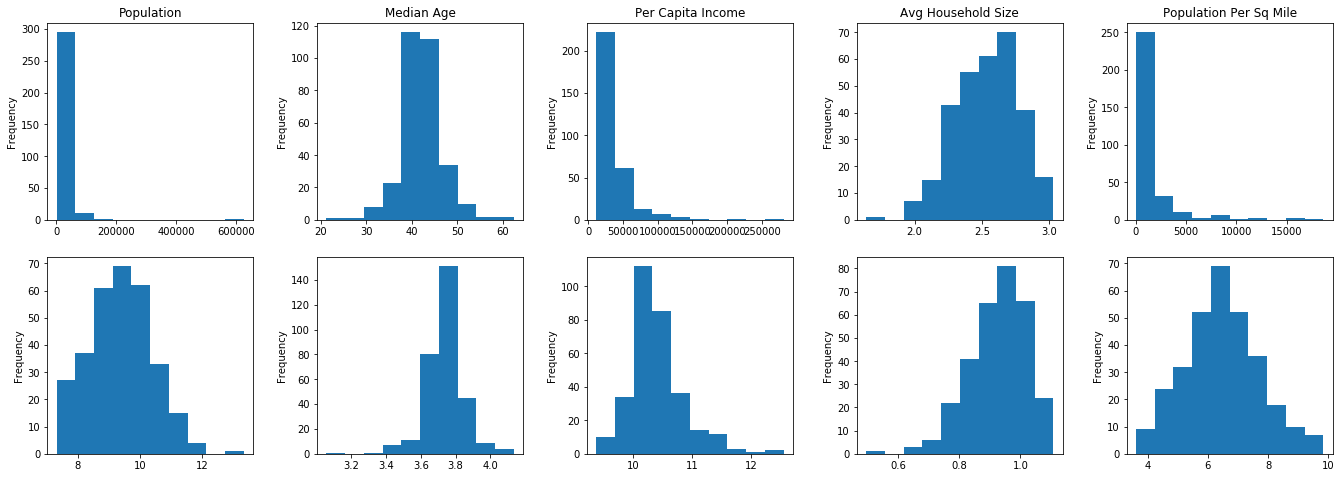

In [1017]:
import matplotlib.pyplot as plt

plt.figure(figsize = [19,7])

plt.subplot(2,5,1)
Mass_data2['Population'].plot(kind = 'hist')
plt.title('Population')

plt.subplot(2,5,2)
Mass_data2['Median Age'].plot(kind = 'hist')
plt.title('Median Age')

plt.subplot(2,5,3)
Mass_data2['Per Capita Income'].plot(kind = 'hist')
plt.title('Per Capita Income')

plt.subplot(2,5,4)
Mass_data2['Avg Household Size'].plot(kind = 'hist')
plt.title('Avg Household Size')

plt.subplot(2,5,5)
Mass_data2['Population per Sq Mile'].plot(kind = 'hist')
plt.title('Population Per Sq Mile')

plt.subplot(2,5,6)
np.log(Mass_data2['Population']).plot(kind = 'hist')

plt.subplot(2,5,7)
np.log(Mass_data2['Median Age']).plot(kind = 'hist')

plt.subplot(2,5,8)
np.log(Mass_data2['Per Capita Income']).plot(kind = 'hist')

plt.subplot(2,5,9)
np.log(Mass_data2['Avg Household Size']).plot(kind = 'hist')

plt.subplot(2,5,10)
np.log(Mass_data2['Population per Sq Mile']).plot(kind = 'hist')

plt.tight_layout(pad = 2)

<H3>Log transformed versions of some data categories are added to dataframes to be used for analysis

In [833]:
Mass_data2['Population (Log)'] = np.log(Mass_data['Population'])
Mass_data2['Per Capita Income (Log)'] = np.log(Mass_data['Per Capita Income'])
Mass_data2['Population per Sq Mile (Log)'] = np.log(Mass_data['Population per Sq Mile'])

In [836]:
conn_data2['Population (Log)'] = np.log(conn_data['Population'])
conn_data2['Per Capita Income (Log)'] = np.log(conn_data['Per Capita Income'])
conn_data2['Population per Sq Mile (Log)'] = np.log(conn_data['Population per Sq Mile'])

<H3>The relationships between the demographic variables and the number of ice cream shops in a town seem to differ between Connecticut and Massachusetts, suggesting that the Connecticut data is a poor training data set.

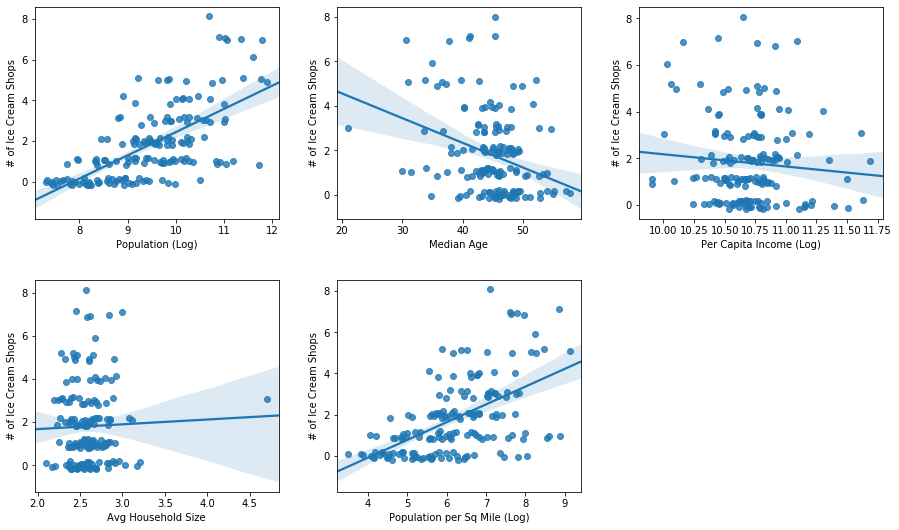

In [1018]:
plt.figure(figsize = [13, 8])

plt.subplot(2,3,1)
sns.regplot(conn_data2['Population (Log)'], conn_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,3,2)
sns.regplot(conn_data2['Median Age'], conn_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,3,3)
sns.regplot(conn_data2['Per Capita Income (Log)'], conn_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,3,4)
sns.regplot(conn_data2['Avg Household Size'], conn_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,3,5)
sns.regplot(conn_data2['Population per Sq Mile (Log)'], conn_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.tight_layout(pad = 3)

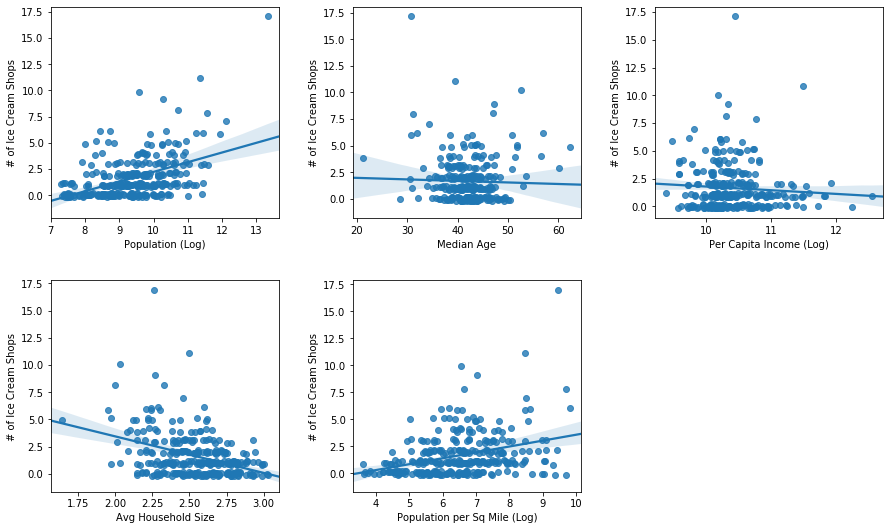

In [1019]:
plt.figure(figsize = [13, 8])

plt.subplot(2,3,1)
sns.regplot(Mass_data2['Population (Log)'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,3,2)
sns.regplot(Mass_data2['Median Age'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,3,3)
sns.regplot(Mass_data2['Per Capita Income (Log)'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,3,4)
sns.regplot(Mass_data2['Avg Household Size'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,3,5)
sns.regplot(Mass_data2['Population per Sq Mile (Log)'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.tight_layout(pad=3)

<H3> A multiple linear regression model is constructed to predict the number of ice cream shops present in a given Massachusetts town. The Connecticut data is used to train the model. The low R-squared value suggests that the chosen independent variable are not strongly predictive of the number of ice cream shops.

In [1021]:
from sklearn import linear_model
from sklearn import preprocessing

regr = linear_model.LinearRegression()
x = conn_data2[['Population (Log)', 'Median Age', 'Per Capita Income (Log)', 'Avg Household Size', 'Population per Sq Mile (Log)']]
y = conn_data2[['# of Ice Cream Shops']]

x = preprocessing.StandardScaler().fit(x).transform(x.astype(float))

regr.fit(x, y)

print('Coefficients:', regr.coef_)
print('R^2: ', regr.score(x, y))

Coefficients: [[ 1.73770445  0.07552752  0.03568423 -0.19309922 -0.48417696]]
R^2:  0.460266406320505


<H3>According to the model, most of the demographic factors have only a small effect on the number of ice cream shops, with the total population is the most predictive factor. Interestingly, controlling for the other factors, the population density has a negative relationship to the number of ice cream shops despite individually having a positive correlation. This is likely due to the strong correlation between total population and population density (below). Once the effect of increased population size is taken into account, increased density decreases the chances of having more ice cream shops. 

Text(0.5, 1.0, 'Population vs Population Density')

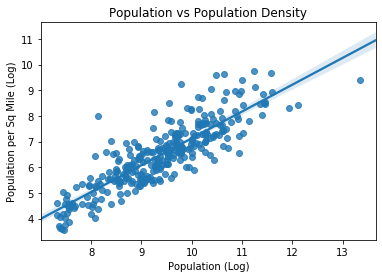

In [1180]:
sns.regplot(Mass_data2['Population (Log)'], Mass_data2['Population per Sq Mile (Log)'], y_jitter = 0.2)
plt.title("Population vs Population Density")

<H3>Since the model is standardized, it predicts that an average increase of 1.74 ice cream shops per standard deviation of increase in the log of the population. Since the standard deviation of population (log) is 1.04, the model thus predicts that for each doubling of a towns population, it should have an extra 1.67 ice creams shops.

In [1170]:
Mass_data2.describe()

,Population,Median Age,Per Capita Income,Avg Household Size,Population per Sq Mile,# of Ice Cream Shops,Population (Log),Per Capita Income (Log),Population per Sq Mile (Log)
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,21206.919094,42.122654,37740.139159,2.536408,1476.777994,1.644013,9.378993,10.407103,6.478287
std,41215.110910,4.508679,26422.391422,0.233833,2544.716189,2.031282,1.038779,0.464710,1.256987
min,1501.000000,21.300000,11893.000000,1.640000,37.100000,0.000000,7.313887,9.383705,3.613617
25%,5907.000000,39.900000,25179.000000,2.380000,274.400000,0.000000,8.683893,10.133766,5.614587
50%,12149.000000,42.100000,30676.000000,2.560000,663.600000,1.000000,9.405002,10.331236,6.497680
75%,24234.000000,44.100000,41233.000000,2.700000,1412.100000,2.000000,10.095512,10.626994,7.252833
max,625087.000000,62.400000,281236.000000,3.030000,18617.800000,17.000000,13.345646,12.546949,9.831873


<H3>The regression model is used to predict the number of ice cream shops in Massachusetts.

In [1022]:
xMA = Mass_data2[['Population (Log)', 'Median Age', 'Per Capita Income (Log)', 'Avg Household Size', 'Population per Sq Mile (Log)']]

xMA = preprocessing.StandardScaler().fit(xMA).transform(xMA.astype(float))

regr.predict(xMA)

array([[ 1.84982922],
       [ 2.56573398],
       [ 1.53621819],
       [ 1.7117676 ],
       [ 3.1700255 ],
       [ 2.15034108],
       [ 3.13726114],
       [ 3.30620698],
       [ 3.25285077],
       [ 1.00133102],
       [-0.01735844],
       [-0.10290328],
       [ 2.06040333],
       [ 1.95512495],
       [ 3.5567663 ],
       [ 2.24277049],
       [-0.02205371],
       [ 1.09566171],
       [ 4.23823979],
       [ 1.0647601 ],
       [-0.03533688],
       [ 1.95039157],
       [ 2.38081077],
       [ 2.07475251],
       [ 2.28373616],
       [ 0.49366367],
       [-0.07177696],
       [-0.14827436],
       [ 3.48169472],
       [ 3.26157195],
       [ 1.14735473],
       [ 0.4451011 ],
       [ 7.34150264],
       [ 2.97244357],
       [ 0.51220323],
       [ 1.1699152 ],
       [ 0.51240295],
       [ 3.09031216],
       [ 2.13866493],
       [ 2.74759747],
       [ 0.51751605],
       [ 4.19661047],
       [ 0.20225467],
       [ 3.65683636],
       [-0.38990871],
       [ 2

<H3>A dataframe is created containing the actual and predicted number of ice cream shops in each town. Predictions of a negative number of shops are converted to zero.

In [1028]:
output = Mass_data2.loc[:, ['# of Ice Cream Shops']]

output['Predicted # of Shops'] = regr.predict(xMA).round(decimals = 1)

In [1066]:
output['Predicted # of Shops'][output['Predicted # of Shops'] < 0] = 0

<H3>There is a positive correlation between predicted and actual values but still a lot of variance in the predicated values.

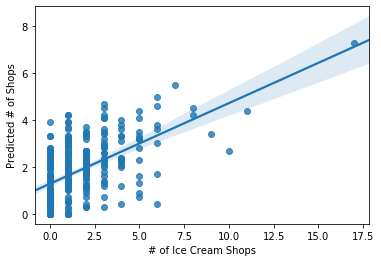

In [1068]:
sns.regplot(output['# of Ice Cream Shops'], output['Predicted # of Shops'])

<H3>The difference between the predicted and actual number of shops is calculated and the data is sorted so that towns are sorted in descending order in terms of how underserved the model thinks they are.

In [1069]:
output['Predicted - Actual'] = (output['Predicted # of Shops'] - output['# of Ice Cream Shops'])

In [1070]:
out_sort = output.sort_values(by = ['Predicted - Actual'], ascending = False)

In [1071]:
out_sort.head(10)

,# of Ice Cream Shops,Predicted # of Shops,Predicted - Actual
Town,,,
LYNN,0,3.9,3.9
MALDEN,0,3.3,3.3
ANDOVER,0,3.3,3.3
FRAMINGHAM,1,4.2,3.2
BROCKTON,1,4.2,3.2
WALTHAM,1,3.9,2.9
WEYMOUTH,1,3.9,2.9
STOUGHTON,0,2.8,2.8
WATERTOWN,0,2.8,2.8


<H3>According to the model, Lynn is the town that is most underserved in its need for additional ice cream shops. A more detailed analysis of the top candidate towns would be needed to determine whether real market opportunities exist in these towns.

<H3>Observing the towns that are the most overserved according to the model shows that many of them are towns on Cape Cod and Martha's Vineyard. Given that these towns have large seasonal tourism in the summer, it is logical that they would have more ice cream shops than other towns with similar demographics. Further, Connecticut does not have many similar towns, leaving the training data unfit to predict these outcomes.

In [1166]:
out_sort.tail(20)

,# of Ice Cream Shops,Predicted # of Shops,Predicted - Actual
Town,,,
FALMOUTH,6,3.8,-2.2
WELLFLEET,3,0.7,-2.3
SOMERVILLE,6,3.6,-2.4
SCITUATE,5,2.3,-2.7
ESSEX,3,0.3,-2.7
EASTHAM,4,1.2,-2.8
BOURNE,6,3.0,-3.0
ORLEANS,5,1.6,-3.4
CAMBRIDGE,8,4.5,-3.5


<H3>To look in more detail at how these beach towns might have influenced the analysis, a list is generated of all towns on Cape Cod and the islands of Martha's Vineyard and Nantucket that have not already been excluded from the analysis due to their small size. This list is then used to make two new dataframes containing the data for the beach towns and all other Massachusetts towns, respectively.

In [972]:
beach_towns = ['FALMOUTH', 'MASHPEE', 'BOURNE', 'SANDWICH', 'BARNSTABLE', 'YARMOUTH', 'DENNIS', 'BREWSTER', 'HARWICH', 'CHATHAM', 'ORLEANS', 'EASTHAM', 'WELLFLEET', 'TRURO', 'PROVINCETOWN', 'EDGARTOWN', 'TISBURY', 'OAK BLUFFS', 'NANTUCKET']

In [1034]:
beach_data = Mass_data2.loc[beach_towns, :]

In [1035]:
no_beach_data = Mass_data2.drop(labels = beach_towns, axis = 0)

<H3>Scatter plots are made comparing each of the Massachusetts demographic factors to the number of ice cream shops, with the beach towns designated by orange dots. In all of the factors the beach towns seem to largely cluster together. In particular, they have a disproportionately high median age and a disproportionately low average household size. Given that they also have a disproportionately high number of ice cream shops, they are potentially biasing the model for those two factors.

Massachusetts demographic data as it relates to # of ice cream shops 
Beach towns (orange) tend to cluster together


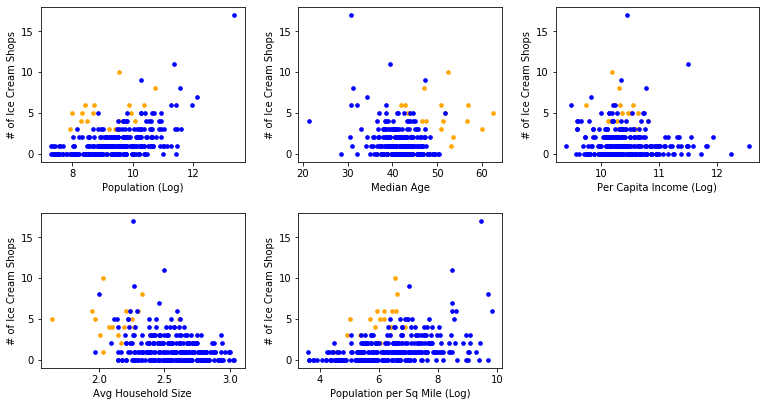

In [1164]:
print('\033[1m'+'Massachusetts demographic data as it relates to # of ice cream shops \nBeach towns (orange) tend to cluster together')

plt.figure(figsize = [11, 6])

plt.subplot(2,3,1)
plt.scatter(beach_data['Population (Log)'], beach_data['# of Ice Cream Shops'], s = 13, c='orange')
plt.scatter(no_beach_data['Population (Log)'], no_beach_data['# of Ice Cream Shops'], s = 13, c='blue')
plt.xlabel('Population (Log)')
plt.ylabel('# of Ice Cream Shops')

plt.subplot(2,3,2)
plt.scatter(beach_data['Median Age'], beach_data['# of Ice Cream Shops'], s = 13, c='orange')
plt.scatter(no_beach_data['Median Age'], no_beach_data['# of Ice Cream Shops'], s = 13, c='blue')
plt.xlabel('Median Age')
plt.ylabel('# of Ice Cream Shops')

plt.subplot(2,3,3)
plt.scatter(beach_data['Per Capita Income (Log)'], beach_data['# of Ice Cream Shops'], s = 13, c='orange')
plt.scatter(no_beach_data['Per Capita Income (Log)'], no_beach_data['# of Ice Cream Shops'], s = 13, c='blue')
plt.xlabel('Per Capita Income (Log)')
plt.ylabel('# of Ice Cream Shops')

plt.subplot(2,3,4)
plt.scatter(beach_data['Avg Household Size'], beach_data['# of Ice Cream Shops'], s = 13, c='orange')
plt.scatter(no_beach_data['Avg Household Size'], no_beach_data['# of Ice Cream Shops'], s = 13, c='blue')
plt.xlabel('Avg Household Size')
plt.ylabel('# of Ice Cream Shops')

plt.subplot(2,3,5)
plt.scatter(beach_data['Population per Sq Mile (Log)'], beach_data['# of Ice Cream Shops'], s = 13, c='orange')
plt.scatter(no_beach_data['Population per Sq Mile (Log)'], no_beach_data['# of Ice Cream Shops'], s = 13, c='blue')
plt.xlabel('Population per Sq Mile (Log)')
plt.ylabel('# of Ice Cream Shops')

plt.tight_layout(pad=2)
plt.show()

<H3>Exclusion of the beach towns from the analysis leads to a noticable shift in the relationship between both median age and average household size and the number of ice cream shops.

                                   Massachusetts data including beach towns                                   


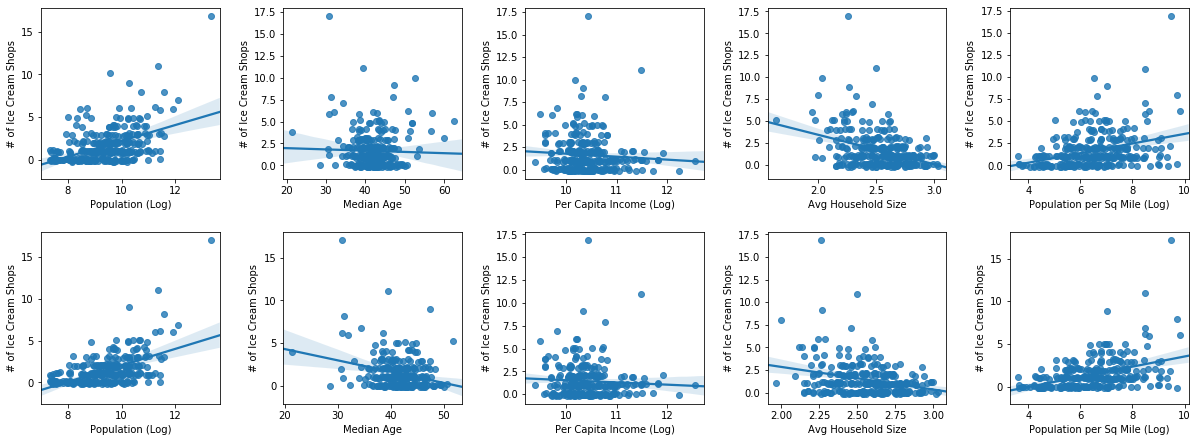

                                    Massachusetts data without beach towns                                    


In [1104]:
print('\033[1m'+'Massachusetts data including beach towns'.center(110))

plt.figure(figsize = [17, 6.5])

plt.subplot(2,5,1)
sns.regplot(Mass_data2['Population (Log)'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,2)
sns.regplot(Mass_data2['Median Age'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,3)
sns.regplot(Mass_data2['Per Capita Income (Log)'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,4)
sns.regplot(Mass_data2['Avg Household Size'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,5)
sns.regplot(Mass_data2['Population per Sq Mile (Log)'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,6)
sns.regplot(no_beach_data['Population (Log)'], no_beach_data['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,7)
sns.regplot(no_beach_data['Median Age'], no_beach_data['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,8)
sns.regplot(no_beach_data['Per Capita Income (Log)'], no_beach_data['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,9)
sns.regplot(no_beach_data['Avg Household Size'], no_beach_data['# of Ice Cream Shops'], y_jitter = 0.2)

plt.subplot(2,5,10)
sns.regplot(no_beach_data['Population per Sq Mile (Log)'], no_beach_data['# of Ice Cream Shops'], y_jitter = 0.2)

plt.tight_layout(pad=2)
plt.show()

print('\033[1m'+'Massachusetts data without beach towns'.center(110))

<H3>The equation for the best fit line relating median age and the number of ice cream shops is strikingly similar between the Connecticut data and the Massachusetts data excluding beach towns, but very different for the Massachusetts data that includes beach towns.

In [1134]:
mM = linear_model.LinearRegression()
mMed = mM.fit(Mass_data2[['Median Age']], Mass_data2[['# of Ice Cream Shops']])
nbM = linear_model.LinearRegression()
nbMed = nbM.fit(no_beach_data[['Median Age']], no_beach_data[['# of Ice Cream Shops']])
cM = linear_model.LinearRegression()
cMed = cM.fit(conn_data2[['Median Age']], conn_data2[['# of Ice Cream Shops']])

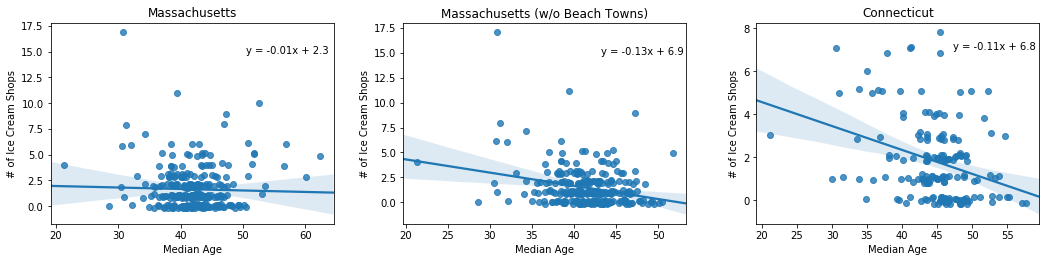

In [1144]:
plt.figure(figsize = [15, 4])

plt.subplot(1,3,1)
sns.regplot(Mass_data2['Median Age'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)
plt.title('Massachusetts')
plt.text(x=50.5 , y=14.8 , s=('y = ' + str(round(float(mMed.coef_), 2)) + 'x + ' + str(round(float(mMed.intercept_), 1))))

plt.subplot(1,3,2)
sns.regplot(no_beach_data['Median Age'], no_beach_data['# of Ice Cream Shops'], y_jitter = 0.2)
plt.title('Massachusetts (w/o Beach Towns)')
plt.text(x=43.2 , y=14.8 , s=('y = ' + str(round(float(nbMed.coef_), 2)) + 'x + ' + str(round(float(nbMed.intercept_), 1))))

plt.subplot(1,3,3)
sns.regplot(conn_data2['Median Age'], conn_data2['# of Ice Cream Shops'], y_jitter = 0.2)
plt.title('Connecticut')
plt.text(x=47.3 , y=7 , s=('y = ' + str(round(float(cMed.coef_), 2)) + 'x + ' + str(round(float(cMed.intercept_), 1))))

plt.tight_layout(pad=2)
plt.show()

<H3>Exclusion of the Massachusetts beach town data also shifts the best fit line relating average household size and the number of ice cream shops. However, the shift is not as drastic as with the median age and there is still a significant between the Massachusetts and Connecticut data.

In [1131]:
mA = linear_model.LinearRegression()
mAvg = mA.fit(Mass_data2[['Avg Household Size']], Mass_data2[['# of Ice Cream Shops']])
nbA = linear_model.LinearRegression()
nbAvg = nbA.fit(no_beach_data[['Avg Household Size']], no_beach_data[['# of Ice Cream Shops']])
cA = linear_model.LinearRegression()
cAvg = cA.fit(conn_data2[['Avg Household Size']], conn_data2[['# of Ice Cream Shops']])

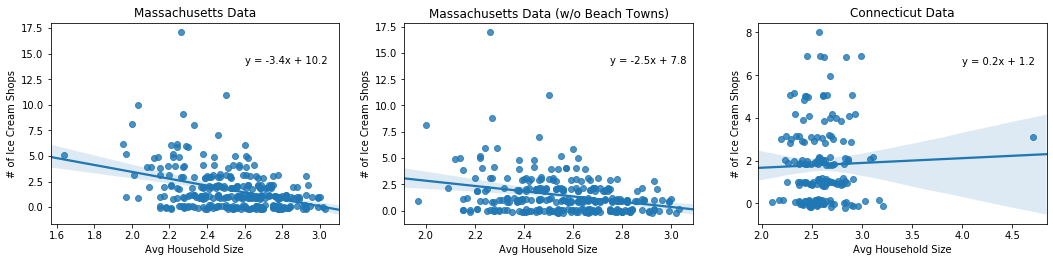

In [1133]:
plt.figure(figsize = [15, 4])

plt.subplot(1,3,1)
sns.regplot(Mass_data2['Avg Household Size'], Mass_data2['# of Ice Cream Shops'], y_jitter = 0.2)
plt.title('Massachusetts Data')
plt.text(x=2.6 , y=14 , s=('y = ' + str(round(float(mAvg.coef_), 1)) + 'x + ' + str(round(float(mAvg.intercept_), 1))))

plt.subplot(1,3,2)
sns.regplot(no_beach_data['Avg Household Size'], no_beach_data['# of Ice Cream Shops'], y_jitter = 0.2)
plt.title('Massachusetts Data (w/o Beach Towns)')
plt.text(x=2.75 , y=14 , s=('y = ' + str(round(float(nbAvg.coef_), 1)) + 'x + ' + str(round(float(nbAvg.intercept_), 1))))

plt.subplot(1,3,3)
sns.regplot(conn_data2['Avg Household Size'], conn_data2['# of Ice Cream Shops'], y_jitter = 0.2)
plt.title('Connecticut Data')
plt.text(x=4 , y=6.5 , s=('y = ' + str(round(float(cAvg.coef_), 1)) + 'x + ' + str(round(float(cAvg.intercept_), 1))))


plt.tight_layout(pad=2)
plt.show()

<H3>The multiple regression model is run again using the only the data from non-beach towns in Massachusetts.

In [1072]:
yMA = no_beach_data[['Population (Log)', 'Median Age', 'Per Capita Income (Log)', 'Avg Household Size', 'Population per Sq Mile (Log)']]

yMA = preprocessing.StandardScaler().fit(yMA).transform(yMA.astype(float))

output2 = no_beach_data.loc[:, ['# of Ice Cream Shops']]

output2['Predicted # of Shops'] = regr.predict(yMA).round(decimals = 1)

output2['Predicted # of Shops'][output2['Predicted # of Shops'] < 0] = 0

<H3>The correlation between the predicted number of ice cream shops and the actual number is compared between the cases where beach towns are included in the analysis and where they are excluded. The increase in the value of R^2 in the latter case demonstrates that these towns are unrepresentative and that their large number of shops is driven by factors not included in the model.

In [1145]:
beach_score = sklearn.metrics.r2_score(output['# of Ice Cream Shops'], output['Predicted # of Shops'])
nobeach_score = sklearn.metrics.r2_score(output2['# of Ice Cream Shops'], output2['Predicted # of Shops'])

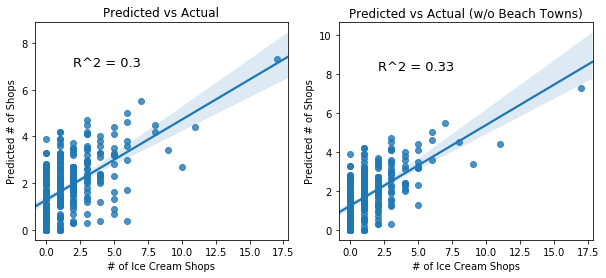

In [1163]:
plt.figure(figsize = [10, 4])

plt.subplot(1,2,1)
sns.regplot(output['# of Ice Cream Shops'], output['Predicted # of Shops'])
plt.title('Predicted vs Actual')
plt.text(x=2 , y=7 , s=('R^2 = ' + str(round(beach_score, 2))), fontsize = 13)

plt.subplot(1,2,2)
sns.regplot(output2['# of Ice Cream Shops'], output2['Predicted # of Shops'])
plt.title('Predicted vs Actual (w/o Beach Towns)')
plt.text(x=2 , y=8.2 , s=('R^2 = ' + str(round(nobeach_score, 2))), fontsize = 13)

plt.show()

<H3>In conclusion, the presence of a large number of beach towns in Massachusetts contributed to an incompatibility between the Connecticut training data and the Massachusetts test data. To address this, a future analysis could expand the training data to a larger number of towns that are more representative of the test data. This phenomenon also suggests a strong correlation between tourism and the presence of ice cream shops, so a future analysis would also be strengthened by inclusion of at least one independent variable that corresponds to the relative level of tourism in each town.